Carga de librerías

In [1]:
import pandas as pd
from mplsoccer import VerticalPitch, Pitch
import matplotlib.pyplot as plt

Carga de datafrane  + transformación de escala 

In [30]:
partido_inicial=pd.read_csv('final2.csv')

# Convertir las columnas a tipo numérico
partido_inicial['Player'] = partido_inicial['Player'].str.strip()
partido_inicial['Y'] = pd.to_numeric(partido_inicial['Y'], errors='coerce')
partido_inicial['X2'] = pd.to_numeric(partido_inicial['X2'], errors='coerce')
partido_inicial['Y2'] = pd.to_numeric(partido_inicial['Y2'], errors='coerce')

# Definir los valores mínimos y máximos de X en ambas escalas
x1, x2 = 0, 100  # Escala original de X
new_x1, new_x2 = 0, 28  # Nueva escala de X

# Definir los valores mínimos y máximos de Y en ambas escalas
y1, y2 = 0, 100  # Escala original de Y
new_y1, new_y2 = 16, 0  # Nueva escala de Y

# Calcular la coordenada transformada de Y y sobrescribir la columna 'Y' con el resultado
partido_inicial['Y'] = ((new_y2 - new_y1) / (y2 - y1)) * partido_inicial['Y']*-1
partido_inicial['Y2'] = ((new_y2 - new_y1) / (y2 - y1)) * partido_inicial['Y2']*-1
# Calcular la coordenada transformada de X y sobrescribir la columna 'X' con el resultado
partido_inicial['X'] = ((new_x2 - new_x1) / (x2 - x1)) * partido_inicial['X'] 
partido_inicial['X2'] = ((new_x2 - new_x1) / (x2 - x1)) * partido_inicial['X2'] 


# Filtrar las filas donde Mins > 55 (entretiempo)
partido_rotado = partido_inicial[partido_inicial['Mins'] > 60].copy()

# Transformar las coordenadas X, Y, X2 y Y2 para las filas donde Mins > MIN ENTRETIEMPO
partido_rotado['X'] = 28 - partido_rotado['X']
partido_rotado['X2'] = 28 - partido_rotado['X2']
partido_rotado['Y'] = 16 - partido_rotado['Y']
partido_rotado['Y2'] = 16 - partido_rotado['Y2']

# Combinar las filas transformadas con las filas originales donde Mins <= MIN ENTRETIEMPO
partido = pd.concat([partido_inicial[partido_inicial['Mins'] <= 60], partido_rotado])


partido_gevp = partido[(partido['Team'] == 'GEVP')]
partido_sitas = partido[(partido['Team'] == 'SITAS')]
# Mostrar las últimas filas del DataFrame combinado
print(partido.head(120))

      Team Player    Event  Mins  Secs      X      Y     X2     Y2
0    SITAS      2     Pase    32    40  23.80   4.96  19.04   0.64
1    SITAS      9     Pase    32    44  19.32   0.64  19.04   6.88
2    SITAS      2     Pase    32    45  19.32   6.56  14.00   7.52
3    SITAS     11     Pase    32    47  14.28   8.00  13.16  12.96
4    SITAS      7     Pase    32    49  12.88  13.44   9.24  15.36
..     ...    ...      ...   ...   ...    ...    ...    ...    ...
115   GEVP     11   Errado    36    55  25.76   7.36    NaN    NaN
116  SITAS      2  reb_def    36    55  22.96   6.24    NaN    NaN
117  SITAS      2     Pase    36    56  22.96   6.24  17.92   3.52
118  SITAS      8  Perdida    36    58  17.92   3.52    NaN    NaN
119   GEVP      5     Pase    37     4  20.16   4.48  22.40   8.48

[120 rows x 9 columns]


Leo players en aprtido

In [31]:

# Obtener los jugadores únicos junto con sus equipos
jugadores_diferentes = partido[['Player', 'Team']].drop_duplicates()

print("Los jugadores diferentes y sus equipos son:")
print(jugadores_diferentes)

Los jugadores diferentes y sus equipos son:
     Player   Team
0         2  SITAS
1         9  SITAS
3        11  SITAS
4         7  SITAS
5        10  SITAS
8         8  SITAS
10        6   GEVP
12       12   GEVP
13       11   GEVP
14        8   GEVP
15        5   GEVP
47        2   GEVP
105       -   GEVP
305       4  SITAS
403       9   GEVP
410      15  SITAS
592       1  SITAS
662       5  SITAS
915      10   GEVP
1254     13   GEVP
1275      4   GEVP


In [32]:
# Filtrar el DataFrame para excluir los eventos 'sub_in' y 'sub_out'
df_player = partido[(partido['Team'] == 'GEVP') & 
                   # (partido['Player'] == '10') & 
                    (~partido['Event'].isin(['sub_in', 'sub_out']))]

# Mostrar el DataFrame resultante
df_player


,Team,Player,Event,Mins,Secs,X,Y,X2,Y2
10,GEVP,6,reb_def,32,59,4.20,6.56,NaN,NaN
11,GEVP,6,Pase,33,0,4.48,6.24,9.24,0.96
12,GEVP,12,Pase,33,2,9.52,1.28,16.24,0.96
13,GEVP,11,Pase,33,3,16.24,1.12,11.20,2.56
14,GEVP,8,Pase,33,5,11.20,2.72,20.44,8.96
...,...,...,...,...,...,...,...,...,...
1368,GEVP,8,Pase,101,50,25.48,13.76,22.40,10.24
1370,GEVP,8,Pase,102,0,25.20,10.88,22.12,9.76
1371,GEVP,12,Gol,102,2,22.12,9.76,NaN,NaN
1388,GEVP,2,Pase,102,36,16.24,15.52,11.76,14.56


In [115]:


# Identificar los índices de los eventos 'Gol' de equipos que no sean 'GEVP'
gol_indices = partido[(partido['Event'] == 'Gol') & (partido['Team'] != 'GEVP')].index

# Identificar los índices de los eventos 'Pase' que siguen a un evento 'Gol' del paso anterior
pase_indices_to_remove = [i + 1 for i in gol_indices if i + 1 in partido.index and partido.loc[i + 1, 'Event'] == 'Pase']

# Crear un nuevo DataFrame excluyendo los eventos 'Pase' identificados
df_filtered = partido.drop(pase_indices_to_remove)

# Si deseas aplicar esta lógica solo a los datos filtrados iniciales
df_player_sitas = df_filtered[(df_filtered['Team'] == 'GEVP') &
                         (df_filtered['Player'] == '4') & 
                         (~partido['Event'].isin(['sub_in', 'sub_out']))]  

# Mostrar el DataFrame resultante
df_player_sitas

,Team,Player,Event,Mins,Secs,X,Y,X2,Y2
1275,GEVP,4,Foul,97,11,12.88,3.68,NaN,NaN
1279,GEVP,4,Foul,97,19,3.92,8.64,NaN,NaN
1289,GEVP,4,Foul,97,45,3.92,5.12,NaN,NaN
1332,GEVP,4,Pase,100,43,12.60,0.16,11.48,4.64
1361,GEVP,4,Foul,101,30,11.48,1.76,NaN,NaN
1364,GEVP,4,Pase,101,45,3.92,12.96,8.12,11.84


In [106]:
def generar_mapa_calor(dataframe, minuto_inicial, minuto_final, ax):
    
    minutes =  dataframe#[(dataframe['Mins'] >= minuto_inicial) & (dataframe['Mins'] <= minuto_final)]
    
    pitch=Pitch()
    
    pitch.kdeplot(
        minutes['Y'],
        minutes['X'],
        ax=ax,
        levels=150,
        fill=True,
        zorder=0,
        shade_lowest=True,
        cmap='Reds')

    
   # Definir las dimensiones del campo
    ancho = 16
    alto = 28

    
    # Dibujar el rectángulo del campo (fondo naranja)
    ax.add_patch(plt.Rectangle((0, 0), ancho, alto, fill=True, color='white', alpha=0.1))

    # Dibujar las líneas de la cancha
    ax.plot([0, ancho], [0, 0], color='black', linewidth=2)  # Línea de fondo
    ax.plot([0, ancho], [alto, alto], color='black', linewidth=2)  # Otra línea de fondo
    ax.plot([0, ancho], [alto/2, alto/2], color='black', linewidth=1)  # Línea central
    ax.plot([0, 0], [0, alto], color='black', linewidth=2)  # Línea lateral izquierda
    ax.plot([ancho, ancho], [0, alto], color='black', linewidth=3)  # Línea lateral derecha


    # Dibujar lineas de penal

    ax.plot( [7.5, 8.5],[ (alto /2)*1.33,  (alto /2)*1.33], color='black', linewidth=2)  # Línea penal
    ax.plot( [7.5, 8.5],[ (alto /2)*0.66,  (alto/2 )*0.66], color='black', linewidth=2)  # Línea penal

    #Aros

    ax.add_patch(plt.Circle((ancho/2 , (alto /2)*1.66), radius=0.5, fill=False, color='red', linewidth=2))
    ax.add_patch(plt.Circle((ancho/2 , (alto/2 )*0.33), radius=0.5, fill=False, color='red', linewidth=2))

    #Circulo de rebote

    ax.add_patch(plt.Circle((ancho/2 , (alto /2)*1.66), radius=2, fill=False, color='black', linewidth=2, linestyle='--'))
    ax.add_patch(plt.Circle((ancho/2 , (alto/2 )*0.33), radius=2, fill=False, color='black', linewidth=2, linestyle='--'))


    # Configurar los ejes
    ax.set_xlim(0, ancho)
    ax.set_ylim(0, alto)
    ax.set_aspect('equal')
    plt.axis('OFF')  # Ocultar ejes

   
    TITLE_TEXT = f'Min {minuto_inicial}-{minuto_final}'
   # text2 = f'Jugadora N°{df_player['Player'].iloc[0]}'
    #ax.text(0, 25, TITLE_TEXT, color='#c7d5cc', va='center', ha='center', fontsize=16)
  #  ax.text(0, 30, text2, color='#c7d5cc', va='center', ha='center', fontsize=18)

Text(1.05, 0.4, '')

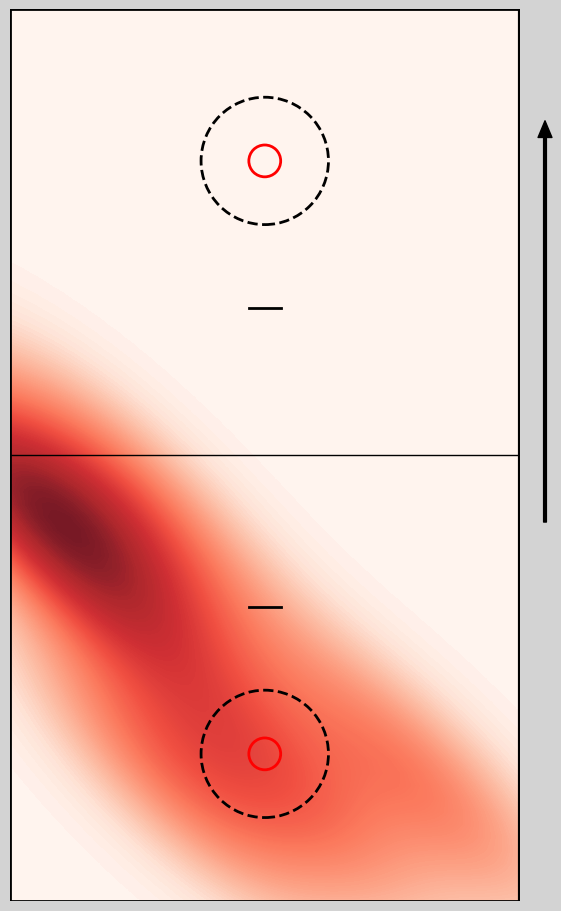

In [116]:
fig = plt.figure(figsize=(16,9),constrained_layout=True)
# Agregar un título a la figura
#fig.suptitle('Jug 11 - SITAS', fontsize=20, color='black')
gs = fig.add_gridspec(nrows=1,ncols=1)
fig.set_facecolor('lightgray')

ax1 = fig.add_subplot(gs[0,0])
generar_mapa_calor(df_player_sitas,25,105,ax1)
ax1.annotate('', xy=(1.05, 0.9), xytext=(1.05, 0.4),
             arrowprops=dict(facecolor='black', shrink=0.05, width=2, headwidth=10),
             xycoords='axes fraction')

# Aquí, invertimos los ejes
#ax1.invert_xaxis()
#ax1.invert_yaxis()

MAPA DE CALOR DE TIROS:


d:\Program Files (x86)\Python\Lib\site-packages\mplsoccer\_pitch_plot.py:170: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  return sns.kdeplot(x=x, y=y, ax=ax, clip=self.kde_clip, **kwargs)


<Axes: >

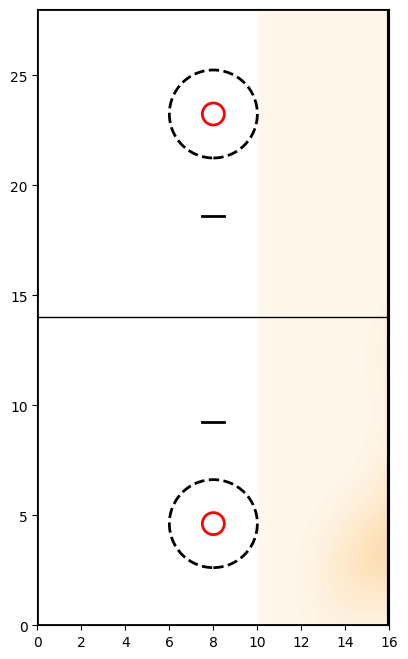

In [118]:
import matplotlib.pyplot as plt
pitch=Pitch()

# Definir las dimensiones del campo
ancho = 16
alto = 28

# Crear una figura y ejes
fig, ax = plt.subplots(figsize=(10,8))  # Ajustar el tamaño de la figura

# Dibujar el rectángulo del campo (fondo naranja)
ax.add_patch(plt.Rectangle((0, 0), ancho, alto,  color='white', alpha=0.1))

# Dibujar las líneas de la cancha
ax.plot([0, ancho], [0, 0], color='black', linewidth=2)  # Línea de fondo
ax.plot([0, ancho], [alto, alto], color='black', linewidth=2)  # Otra línea de fondo
ax.plot([0, ancho], [alto/2, alto/2], color='black', linewidth=1)  # Línea central
ax.plot([0, 0], [0, alto], color='black', linewidth=2)  # Línea lateral izquierda
ax.plot([ancho, ancho], [0, alto], color='black', linewidth=3)  # Línea lateral derecha


# Dibujar lineas de penal

ax.plot( [7.5, 8.5],[ (alto /2)*1.33,  (alto /2)*1.33], color='black', linewidth=2)  # Línea penal
ax.plot( [7.5, 8.5],[ (alto /2)*0.66,  (alto/2 )*0.66], color='black', linewidth=2)  # Línea penal

#Aros

ax.add_patch(plt.Circle((ancho/2 , (alto /2)*1.66), radius=0.5, fill=False, color='red', linewidth=2))
ax.add_patch(plt.Circle((ancho/2 , (alto/2 )*0.33), radius=0.5, fill=False, color='red', linewidth=2))

#Circulo de rebote

ax.add_patch(plt.Circle((ancho/2 , (alto /2)*1.66), radius=2, fill=False, color='black', linewidth=2, linestyle='--'))
ax.add_patch(plt.Circle((ancho/2 , (alto/2 )*0.33), radius=2, fill=False, color='black', linewidth=2, linestyle='--'))


# Configurar los ejes
ax.set_xlim(0, ancho)
ax.set_ylim(0, alto)
ax.set_aspect('equal')
plt.axis('on')  # Ocultar ejes



pitch.kdeplot(
    df_player[(df_player['Event'].isin(['Gol']))]['X'] ,
    df_player[(df_player['Event'].isin(['Gol']))]['Y'],
    ax=ax,
    levels=100,
    shade=True,
    zorder=-1,
    shade_lowest=True,
    cmap='OrRd'
)